# This is the simpliest pipeline of Fian.

## There are 3 phases

- Intent Detection a.k.a NLP layers

- Feature Selection

- Respond

# Phase 1 - Intent Detection

1. Input Preprocessing

1. Extract user's intent (using TF-IDF + Logistic Regression)

First, for good measure, I will train the model first (train it once and give out a joblib file, but they are here for visualizations)

P.S: If you are seeing model and such, means that the part is under developement

Second, I will use the model to predict what's the user's intent


In [4]:
# NLP SpaCy "en_core_web_trf"
import re
import spacy
import yfinance as yf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from joblib import load

nlp = spacy.load("en_core_web_trf")
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

## == == == -- -- -- Helper Functions -- -- -- == == == ##

def preprocess_query(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(tokens)


def run_NER(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

def extract_entities(entities, label):
    return [ent_text for ent_text, ent_label in entities if ent_label == label]

def to_yf_period(text):
    match = re.search(r'(\d+)\s*(year|years|month|months|week|weeks|day|days)', text, re.IGNORECASE)
    if match:
        number = match.group(1)
        unit = match.group(2).lower()

        if 'year' in unit:
            return f"{number}y"
        elif 'month' in unit:
            return f"{number}mo"
        elif 'week' in unit:
            days = int(number) * 7
            return f"{days}d"
        elif 'day' in unit:
            return f"{number}d"
    return None

def yfinance_search_company(company_names):
    results = {}
    for name in company_names:
        s = yf.Search(name, max_results=1)
        if s.quotes:
            results[name] = s.quotes[0].get("symbol")
        else:
            results[name] = None
    # Return a list of ticker symbols (filtering out any None values)
    return [ticker for ticker in results.values() if ticker]

## == == == -- -- -- Main Execute Functions -- -- -- == == == ##

def extract_tickers(text):
    entities = run_NER(text)
    company_names = extract_entities(entities, "ORG")
    tickers = yfinance_search_company(company_names)
    return tickers

# Load the trained logistic regression intent classifier
intent_classifier = load("intent_with_LogisticRegression.joblib")

def extract_intent(text):
    processed_text = preprocess_query(text)
    # The classifier expects a list/array of texts
    predicted = intent_classifier.predict([processed_text])
    return predicted[0]

def extract_period(text):
    entities = run_NER(text)
    date_entities = extract_entities(entities, "DATE")

    if len(date_entities) >= 2: 
        print("Multiple Date Ranges are not compatible YET. I will add later. Default: max") 
        return "max"

    if len(date_entities) == 1:
        period = to_yf_period(text)
        if period:
            return period
        else:
            return "max"  

    return "max"
def extract_indicator(text):
    return "SMA_50"

while True:
    raw_query = input("Enter your stock query (or type 'exit' or 'quit' to quit): ")
    if raw_query.lower() in ['exit', 'quit']:
        break

    intent = extract_intent(raw_query)
    period = extract_period(raw_query)
    tickers = extract_tickers(raw_query)
    indicators = extract_indicator(raw_query) if intent in ["calculate", "predict"] else None

    print("Intent:", intent)
    print("Period:", period)
    print("Tickers:", tickers)
    print("Indicators:", indicators)





d:\Python\python313\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\Python\python313\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\Python\python313\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.7.0. This might lead to breaking code or

Intent: shows_info
Period: max
Tickers: []
Indicators: None
Intent: calculate
Period: 1y
Tickers: ['AAPL']
Indicators: SMA_50
Intent: shows_info
Period: max
Tickers: []
Indicators: None


Fetching data for AAPL...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


=== First 10 rows ===
Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2022-06-07  146.361877  146.647292  141.824669  142.070721   67808200
2022-06-08  145.623718  147.503548  145.131613  146.233924   53950200
2022-06-09  140.387711  145.613863  140.279447  144.757605   69473000
2022-06-10  134.964722  138.537394  134.895820  138.064977   91437900
2022-06-13  129.797607  133.065177  129.364553  130.771966  122207100
2022-06-14  130.663727  131.775889  129.403939  131.027895   84784300
2022-06-15  133.291565  135.171410  130.073209  132.169566   91533000
2022-06-16  128.006317  130.299528  127.002419  129.994425  108123900
2022-06-17  129.482666  130.978669  127.760299  128.016203  134520300
2022-06-21  133.724579  134.895791  131.214856  131.313268   81000500


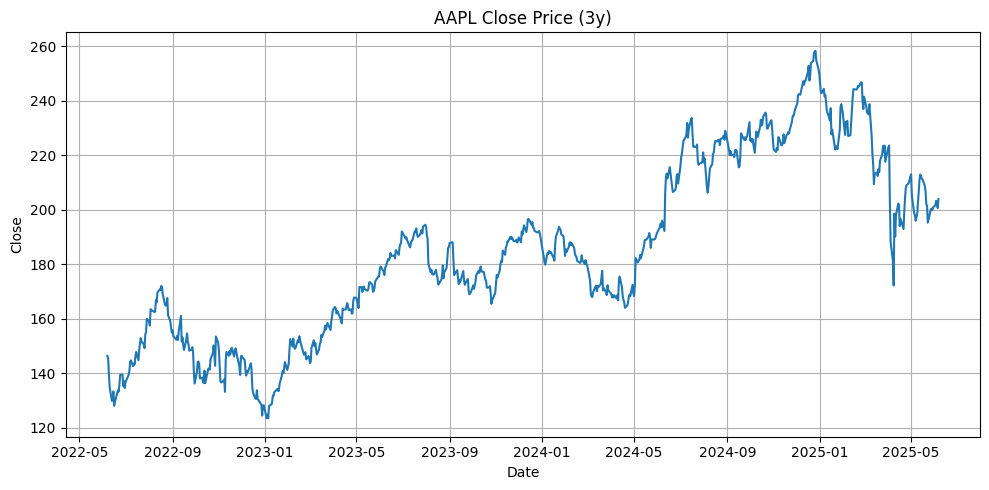

Fetching data for NVDA...


[*********************100%***********************]  1 of 1 completed

=== First 10 rows ===
Price           Close       High        Low       Open     Volume
Ticker           NVDA       NVDA       NVDA       NVDA       NVDA
Date                                                             
2022-06-07  18.896059  18.969941  18.159226  18.442777  388914000
2022-06-08  18.622437  19.153707  18.509591  18.773229  363252000
2022-06-09  18.023258  18.907045  18.016268  18.455665  395574000
2022-06-10  16.950729  17.672738  16.845872  17.575871  465248000
2022-06-13  15.625547  16.289636  15.584603  15.978063  604153000
2022-06-14  15.814289  16.043973  15.390870  15.709433  469680000
2022-06-15  16.504341  16.844873  15.904164  16.072932  563936000
2022-06-16  15.579610  15.920143  15.379884  15.838255  545749000
2022-06-17  15.858229  15.973071  15.306985  15.626546  630334000
2022-06-21  16.543289  16.984683  16.384507  16.452414  483089000


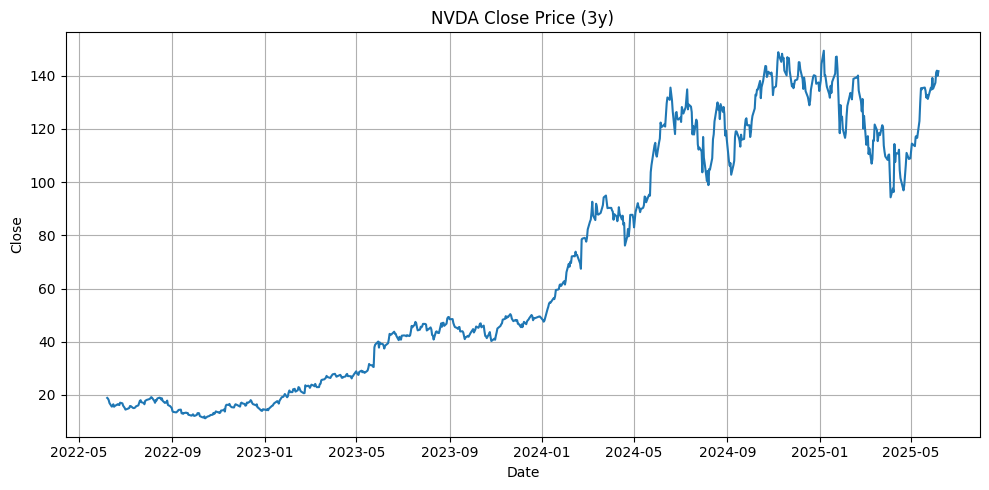

Fetching data for MSFT...


[*********************100%***********************]  1 of 1 completed

=== First 10 rows ===
Price            Close        High         Low        Open    Volume
Ticker            MSFT        MSFT        MSFT        MSFT      MSFT
Date                                                                
2022-06-07  265.758728  266.373147  259.361016  260.043711  22860700
2022-06-08  263.720398  266.246321  262.940171  264.988226  17372300
2022-06-09  258.239502  265.963556  258.083457  261.155524  26439700
2022-06-10  246.731400  254.133615  246.282773  254.133615  31422800
2022-06-13  236.266830  242.859607  235.554894  239.046331  46135800
2022-06-14  238.441696  239.660773  235.535406  237.827277  28651500
2022-06-15  245.531799  248.984233  240.323907  242.167151  33111700
2022-06-16  238.909805  241.299193  237.008048  239.894814  33169200
2022-06-17  241.523483  244.302984  237.993042  238.646465  43084800
2022-06-21  247.462845  248.447854  243.337478  244.068924  29928300


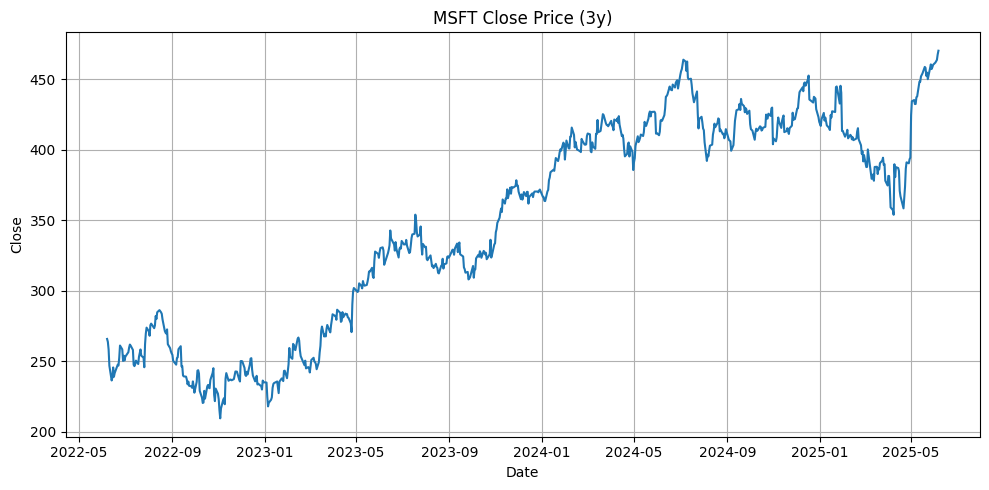

In [3]:
# show_infos function
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

## == == == -- -- -- Helper Functions -- -- -- == == == ##

def extract_data_yf(ticker, Period = "1y"):
    df = yf.download(ticker, period=Period, interval="1d")
    return df

def display_stock(df, n_rows: int = 10):

    print(f"=== First {n_rows} rows ===")
    print(df.head(n_rows).to_string())
    # print(f"\n=== Last {n_rows} rows ===")
    # print(df.tail(n_rows).to_string())
    # print("\n=== Descriptive Statistics ===")
    # print(df.describe().round(2).to_string())

def line_graph(df, field: str = "Close", title: str = None):

    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df[field])
    plt.xlabel("Date")
    plt.ylabel(field)
    plt.title(title or f"{field} Price Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## == == == -- -- -- Main Execute Function -- -- -- == == == ##

def show_infos(ticker: str, period: str = "1y", visual: bool = True):

    # 1) Fetch the data
    df = extract_data_yf(ticker, period)

    # 2) Print a table summary
    display_stock(df)

    # 3) Plot if requested
    if visual:
        line_graph(df, title=f"{ticker.upper()} Close Price ({period})")

    return df



if intent == "show_infos":
    for ticker in tickers:
        print(f"Fetching data for {ticker}...")
        df = show_infos(ticker, period)

## Feature Selection

Below, we start selecting what code to execute

In [9]:
from collections import OrderedDict
import ta
import pandas as pd
# Define 30 most used technical indicators using 'ta' library
indicator_funcs = OrderedDict({
    # Trend indicators
    "EMA_10": lambda df: ta.trend.EMAIndicator(close=df["Close"], window=10).ema_indicator(),
    "WMA_10": lambda df: ta.trend.WMAIndicator(close=df["Close"], window=10).wma(),
    "DEMA_10": lambda df: ta.trend.DEMAIndicator(close=df["Close"], window=10).dema_indicator(),
    "TEMA_10": lambda df: ta.trend.TEMAIndicator(close=df["Close"], window=10).tema_indicator(),
    "MACD": lambda df: ta.trend.MACD(close=df["Close"]).macd(),
    "MACD_signal": lambda df: ta.trend.MACD(close=df["Close"]).macd_signal(),
    "MACD_diff": lambda df: ta.trend.MACD(close=df["Close"]).macd_diff(),
    "ADX": lambda df: ta.trend.ADXIndicator(high=df["High"], low=df["Low"], close=df["Close"]).adx(),
    "CCI": lambda df: ta.trend.CCIIndicator(high=df["High"], low=df["Low"], close=df["Close"]).cci(),
    "Ichimoku_a": lambda df: ta.trend.IchimokuIndicator(high=df["High"], low=df["Low"]).ichimoku_a(),
    "Ichimoku_b": lambda df: ta.trend.IchimokuIndicator(high=df["High"], low=df["Low"]).ichimoku_b(),
    "PSAR": lambda df: ta.trend.PSARIndicator(high=df["High"], low=df["Low"], close=df["Close"]).psar(),
    "STC": lambda df: ta.trend.STCIndicator(close=df["Close"]).stc(),

    # Momentum indicators
    "RSI": lambda df: ta.momentum.RSIIndicator(close=df["Close"]).rsi(),
    "Stoch": lambda df: ta.momentum.StochasticOscillator(high=df["High"], low=df["Low"], close=df["Close"]).stoch(),
    "Stoch_signal": lambda df: ta.momentum.StochasticOscillator(high=df["High"], low=df["Low"], close=df["Close"]).stoch_signal(),
    "AwesomeOsc": lambda df: ta.momentum.AwesomeOscillatorIndicator(high=df["High"], low=df["Low"]).awesome_oscillator(),
    "KAMA": lambda df: ta.momentum.KAMAIndicator(close=df["Close"]).kama(),
    "ROC": lambda df: ta.momentum.ROCIndicator(close=df["Close"]).roc(),
    "TSI": lambda df: ta.momentum.TSIIndicator(close=df["Close"]).tsi(),
    "UO": lambda df: ta.momentum.UltimateOscillator(high=df["High"], low=df["Low"], close=df["Close"]).ultimate_oscillator(),

    # Volatility indicators
    "ATR": lambda df: ta.volatility.AverageTrueRange(high=df["High"], low=df["Low"], close=df["Close"]).average_true_range(),
    "Bollinger_hband": lambda df: ta.volatility.BollingerBands(close=df["Close"]).bollinger_hband(),
    "Bollinger_lband": lambda df: ta.volatility.BollingerBands(close=df["Close"]).bollinger_lband(),
    "Bollinger_mavg": lambda df: ta.volatility.BollingerBands(close=df["Close"]).bollinger_mavg(),
    "Donchian_hband": lambda df: ta.volatility.DonchianChannel(high=df["High"], low=df["Low"]).donchian_channel_hband(),
    "Donchian_lband": lambda df: ta.volatility.DonchianChannel(high=df["High"], low=df["Low"]).donchian_channel_lband(),
    "Keltner_hband": lambda df: ta.volatility.KeltnerChannel(high=df["High"], low=df["Low"], close=df["Close"]).keltner_channel_hband(),
    "Keltner_lband": lambda df: ta.volatility.KeltnerChannel(high=df["High"], low=df["Low"], close=df["Close"]).keltner_channel_lband(),
    "Donchian_width": lambda df: ta.volatility.DonchianChannel(high=df["High"], low=df["Low"]).donchian_channel_width(),
})

# Add SMA with different window sizes to indicator_funcs
for win in [5, 10, 20, 50, 100, 200]:
    indicator_funcs[f"SMA_{win}"] = lambda df, w=win: ta.trend.SMAIndicator(close=df["Close"], window=w).sma_indicator()


# Test each indicator in indicator_funcs and print out the total working
def test_indicators(df, indicator_funcs):
    working_count = 0
    total_count = len(indicator_funcs)
    print("Testing indicators:")
    for name, func in indicator_funcs.items():
        try:
            result = func(df.rename(columns={
                "Close_AAPL": "Close",
                "High_AAPL": "High",
                "Low_AAPL": "Low",
                "Open_AAPL": "Open",
                "Volume_AAPL": "Volume"
            }))
            if hasattr(result, 'shape'):
                print(f"  {name}: OK (shape={result.shape})")
            else:
                print(f"  {name}: OK")
            working_count += 1
        except Exception as e:
            print(f"  {name}: FAIL ({e})")
    print(f"\nTotal working: {working_count}/{total_count}\n")
    return working_count, total_count

# Flatten the nested indicator_funcs dictionary into a single-level OrderedDict
def flatten_indicator_funcs(indicator_funcs):
    flat = OrderedDict()
    for key, value in indicator_funcs.items():
        if isinstance(value, dict):
            for subkey, subval in value.items():
                flat[subkey] = subval
        else:
            flat[key] = value
    return flat

indicator_funcs = flatten_indicator_funcs(indicator_funcs)

def calculate_TI(df, indicators=None):
    # If the DataFrame has MultiIndex columns, flatten them for easier access
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join([str(i) for i in col if i]) for col in df.columns.values]

    # Ensure required columns exist for indicator calculations
    required_cols = ['Close', 'High', 'Low', 'Open', 'Volume']
    # Try to find columns that match required names (case-insensitive, partial match)
    col_map = {}
    for col in required_cols:
        matches = [c for c in df.columns if col.lower() in c.lower()]
        if matches:
            col_map[col] = matches[0]
        else:
            raise ValueError(f"Required column '{col}' not found in DataFrame columns: {df.columns}")

    # Create a working DataFrame with standard column names for TA-Lib
    df_ta = df.rename(columns={v: k for k, v in col_map.items()})

    # Calculate indicators and add them to the original DataFrame
    if indicators is not None:
        for ind in indicators:
            if ind in indicator_funcs:
                try:
                    df[ind] = indicator_funcs[ind](df_ta)
                except Exception as e:
                    print(f"Could not calculate {ind}: {e}")

    return df

# Test: Calculate SMA50 and display the last 5 values
df_with_sma = calculate_TI(df.copy(), indicators=["SMA_10"])
print(df_with_sma[["Close_AAPL", "SMA_10"]].tail())


KeyError: "['Close_AAPL'] not in index"

In [ ]:
if intent == "show_infos":
    for ticker in tickers:
        print(f"Fetching data for {ticker}...")
        df = show_infos(ticker, period)


if intent == "calculate_indicator":
    # Example: calculate only a few selected indicators for df
    selected_indicators = ["RSI", "SMA_10"]
    df_with_indicators = df.copy()
    for ind in selected_indicators:
        if ind in indicator_funcs:
            try:
                df_with_indicators[ind] = indicator_funcs[ind](df_with_indicators)
            except Exception as e:
                print(f"Could not calculate {ind}: {e}")
    print(df_with_indicators[[*df_with_indicators.columns[:5], *selected_indicators]].tail())

    if intent == "predict_indicator":
        print("Prediction functionality is not implemented yet.")


SyntaxError: invalid syntax (3041434619.py, line 19)

In [ ]:
# Simple input query for user
user_query = input("Enter your stock query: ")

# Example usage with the pipeline
intent = extract_intent(user_query)
period = extract_period(user_query)
tickers = extract_tickers(user_query)
print("Intent:", intent)
print("Period:", period)
print("Tickers:", tickers)

## Phase 3: NLG using Gemma 2b